### 総合演習データパイプライン

* 入力：CSVファイル ("C:\Users\Admin\ILP\Python-AI\raw_data.csv")
* FeatherL:C:\Users\81803\ILP\Python-AI\merged_data.feather
* 出力：

In [1]:
#必要なライブラリ
import pandas as pd
import numpy as np
import pyarrow.feather as feather
from sklearn.preprocessing import LabelEncoder

In [11]:
df = pd.read_csv('./data/raw_data.csv',encoding='utf-8')
df.head()

,日付,予約件数,予約人数,来客数,総杯数,売上合計(円),ペールエール(本),ペールエール(円),ラガー(本),ラガー(円),IPA(本),IPA(円),ホワイトビール(本),ホワイトビール(円),黒ビール(本),黒ビール(円),フルーツビール(本),フルーツビール(円)
0,2024/04/01,NaN,NaN,21,33,"31,800",10,"10,000",10,"8,000",5,"4,500",5,"4,500",4,"4,800",NaN,NaN
1,2024/04/02,NaN,NaN,13,25,"23,300",8,"8,000",7,"5,600",3,"2,700",4,"3,600",2,"2,400",1,"1,000"
2,2024/04/03,NaN,NaN,20,36,"33,600",7,"7,000",8,"6,400",6,"5,400",6,"5,400",2,"2,400",7,"7,000"
3,2024/04/04,NaN,NaN,17,27,"24,600",6,"6,000",9,"7,200",4,"3,600",4,"3,600",1,"1,200",3,"3,000"
4,2024/04/05,2,5,29,61,"56,500",15,"15,000",18,"14,400",9,"8,100",8,"7,200",4,"4,800",7,"7,000"


In [14]:
import pandas as pd

df = pd.read_csv('./data/raw_data.csv', encoding='utf-8')

# 1. 过滤掉 '日付'、空行或其它异常值
mask = df['日付'].astype(str).str.match(r'^\d{4}/\d{1,2}/\d{1,2}$')
df = df.loc[mask].copy()

# 2. 解析为 datetime
df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)

# 3. 验证
print(df['日付'].head())
print(df.info())


0   2024-04-01
1   2024-04-02
2   2024-04-03
3   2024-04-04
4   2024-04-05
Name: 日付, dtype: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 0 to 325
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   日付          315 non-null    datetime64[ns]
 1   予約件数        28 non-null     object        
 2   予約人数        47 non-null     object        
 3   来客数         314 non-null    object        
 4   総杯数         314 non-null    object        
 5   売上合計(円)     313 non-null    object        
 6   ペールエール(本)   310 non-null    object        
 7   ペールエール(円)   310 non-null    object        
 8   ラガー(本)      307 non-null    object        
 9   ラガー(円)      307 non-null    object        
 10  IPA(本)      286 non-null    object        
 11  IPA(円)      285 non-null    object        
 12  ホワイトビール(本)  259 non-null    object        
 13  ホワイトビール(円)  257 non-null    object        
 14  黒ビール(本)     233 non-

C:\Users\81803\AppData\Local\Temp\ipykernel_6072\2808381903.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)


In [15]:
# 定义包含各品类销售额的列名
sales_cols = [
    'ペールエール(円)',
    'ラガー(円)',
    'IPA(円)',
    'ホワイトビール(円)',
    '黒ビール(円)',
    'フルーツビール(円)'
]

# 去掉千分位逗号并转成数值
for col in sales_cols + ['売上合計(円)']:
    df[col] = (
        df[col]
        .fillna('0')            # 将 NaN 当作 "0" 处理
        .astype(str)
        .str.replace(',', '')   # 移除逗号
        .astype(float)          # 转为 float
    )

# 重新计算総売上額
df['総売上額'] = df[sales_cols].sum(axis=1)

# 查看原始合计和重新计算的对比
print(df[['日付', '売上合計(円)', '総売上額']].head())


          日付  売上合計(円)     総売上額
0 2024-04-01  31800.0  31800.0
1 2024-04-02  23300.0  23300.0
2 2024-04-03  33600.0  33600.0
3 2024-04-04  24600.0  24600.0
4 2024-04-05  56500.0  56500.0


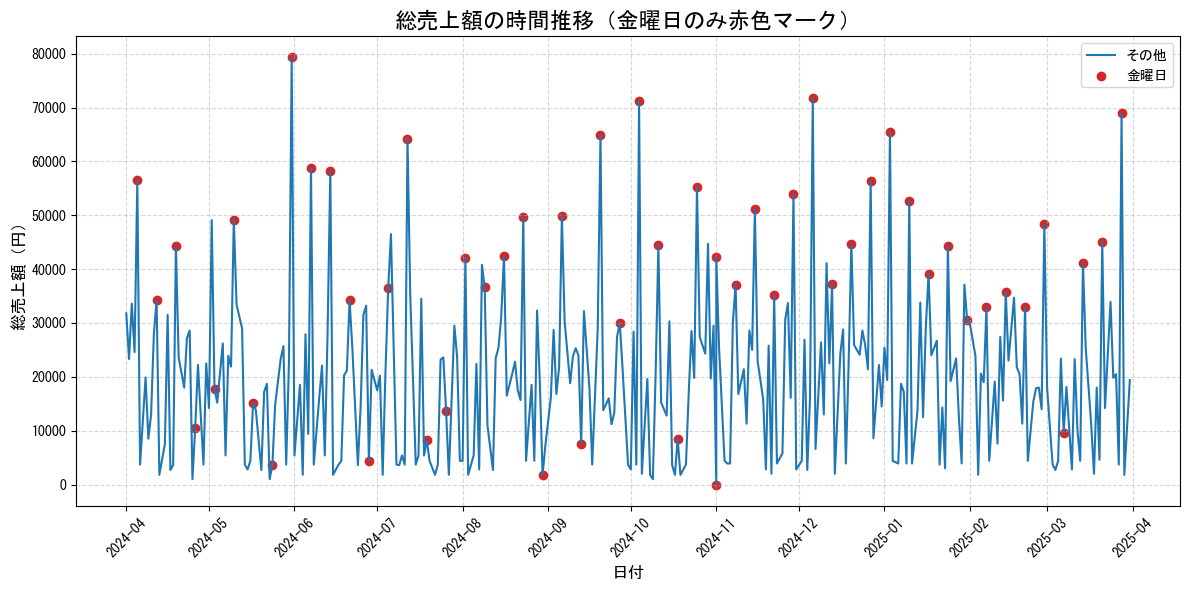

In [25]:
# ...existing code...
dates = df['日付']
sales = df['総売上額']
friday_mask = dates.dt.weekday == 4  # 金曜日のみ

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates, sales, linestyle='-', label='その他', color='tab:blue')
ax.scatter(dates[friday_mask], sales[friday_mask],
           color='tab:red', marker='o', label='金曜日')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax.legend()
ax.set_title('総売上額の時間推移（金曜日のみ赤色マーク）', fontsize=16)
ax.set_xlabel('日付', fontsize=12)
ax.set_ylabel('総売上額（円）', fontsize=12)

ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# ...existing code...

In [28]:
beer_sales_cols = [
    'ペールエール(円)',
    'ラガー(円)',
    'IPA(円)',
    'ホワイトビール(円)',
    '黒ビール(円)',
    'フルーツビール(円)',
    '総売上額'
]
df_selected = df[['日付'] + beer_sales_cols].copy()
df_selected.head()

,日付,ペールエール(円),ラガー(円),IPA(円),ホワイトビール(円),黒ビール(円),フルーツビール(円),総売上額
0,2024-04-01,10000.0,8000.0,4500.0,4500.0,4800.0,0.0,31800.0
1,2024-04-02,8000.0,5600.0,2700.0,3600.0,2400.0,1000.0,23300.0
2,2024-04-03,7000.0,6400.0,5400.0,5400.0,2400.0,7000.0,33600.0
3,2024-04-04,6000.0,7200.0,3600.0,3600.0,1200.0,3000.0,24600.0
4,2024-04-05,15000.0,14400.0,8100.0,7200.0,4800.0,7000.0,56500.0


In [31]:
# ...existing code...
# 各品种啤酒销售额の列
beer_sales_cols = [
    'ペールエール(円)',
    'ラガー(円)',
    'IPA(円)',
    'ホワイトビール(円)',
    '黒ビール(円)',
    'フルーツビール(円)'
]

# 各行で比較
df_selected['品种合計'] = df_selected[beer_sales_cols].sum(axis=1)
df_selected['一致'] = df_selected['総売上額'] == df_selected['品种合計']

# 不一致の行を表示
mismatch = df_selected[~df_selected['一致']]
print(f"不一致の行数: {len(mismatch)}")
if not mismatch.empty:
    display(mismatch[['日付', '総売上額', '品种合計'] + beer_sales_cols])
else:
    print("すべて一致しています。")
# ...existing code...

不一致の行数: 0
すべて一致しています。


In [32]:
df_selected.to_feather('beer_sales_selected.feather')

In [48]:
merged_df.to_feather('merged_data.feather')

In [71]:
df = feather.read_feather('merged_data.feather')
df.columns.unique()

Index(['日付', '平均気温(℃)', '日照時間(時間)', '降雪量合計(cm)', '平均湿度(％)', '最高気温(℃)',
       '最低気温(℃)', '10分間降水量の最大(mm)', '天気概況(昼：06時～18時)', '天気概況(夜：18時～翌日06時)',
       'ペールエール(円)', 'ラガー(円)', 'IPA(円)', 'ホワイトビール(円)', '黒ビール(円)', 'フルーツビール(円)',
       '総売上額'],
      dtype='object')

In [73]:
df.to_json('./data/merged_data.json', orient='records', force_ascii=False, lines=True)

In [36]:
# ...existing code...
# 1. 不要な列を削除
drop_cols = [
    '来客数', '総杯数', 'ペールエール(本)', 'ラガー(本)', 'ラガー(円)', 'IPA(本)', 'IPA(円)',
    'ホワイトビール(本)', 'ホワイトビール(円)', '黒ビール(本)', 'フルーツビール(本)'
]
df_cleaned = df.drop(columns=drop_cols, errors='ignore')

# 2. df_cleanedとdf_selectedを日付でマージ
merged_df = pd.merge(df_cleaned, df_selected, on='日付', suffixes=('_orig', '_selected'))

# 必要なら保存
merged_df.drop(columns=['一致', '品种合計'], inplace=True, errors='ignore')
merged_df.head()
# 保存マージされたデータ
merged_df.to_feather('merged_data.feather')
# ...existing code...

In [38]:
df = feather.read_feather('merged_data.feather')
df.columns.unique()

Index(['日付', '平均気温(℃)', '日照時間(時間)', '降雪量合計(cm)', '平均湿度(％)', '最高気温(℃)',
       '最低気温(℃)', '10分間降水量の最大(mm)', '天気概況(昼：06時～18時)', '天気概況(夜：18時～翌日06時)',
       'ペールエール(円)', 'ラガー(円)', 'IPA(円)', 'ホワイトビール(円)', '黒ビール(円)', 'フルーツビール(円)',
       '総売上額'],
      dtype='object')

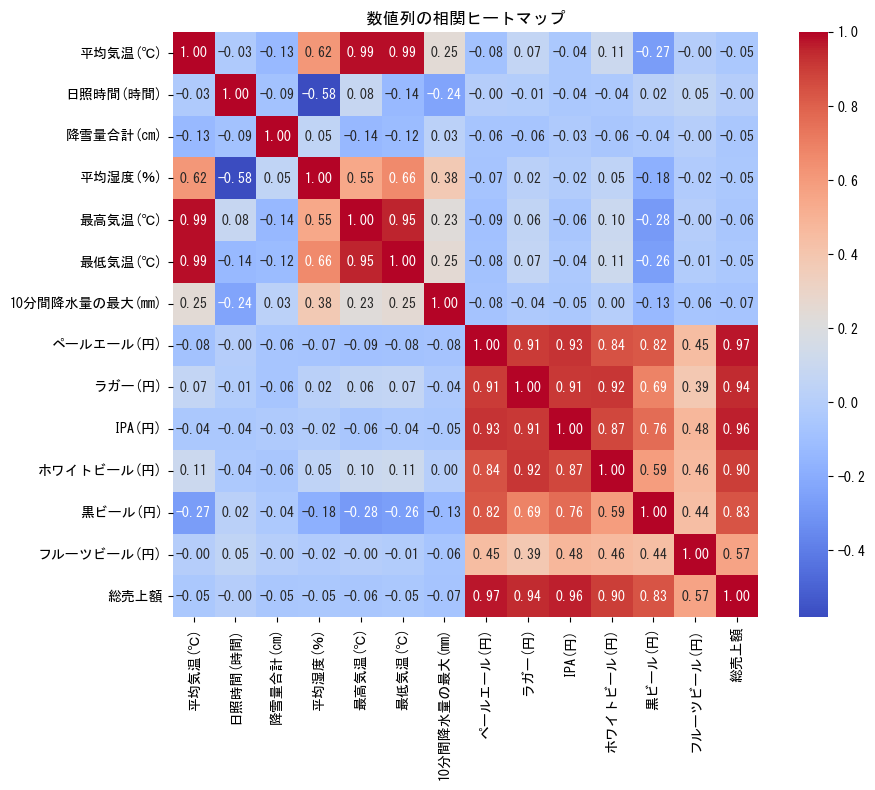

In [40]:
# ...existing code...
import seaborn as sns
import matplotlib.pyplot as plt

# 数値列のみ抽出
corr = merged_df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('数値列の相関ヒートマップ')
plt.tight_layout()
plt.show()
# ...existing code...

                      ペールエール(円)        ラガー(円)       IPA(円)   ホワイトビール(円)  \
天気概況(夜：18時～翌日06時)                                                         
大雨                  7333.333333   5066.666667  3000.000000  2700.000000   
大雨時々曇、雷を伴う          1000.000000   1200.000000   450.000000   450.000000   
快晴                  6413.043478   4208.695652  2817.391304  2073.913043   
晴                   8482.758621   6289.655172  3786.206897  3289.655172   
晴一時曇                6357.142857   4914.285714  3407.142857  2250.000000   
晴一時薄曇               7666.666667   5333.333333  3900.000000  2400.000000   
晴後一時曇               7833.333333   5266.666667  3225.000000  2550.000000   
晴後一時薄曇              9555.555556   7644.444444  4400.000000  3900.000000   
晴後曇                 4833.333333   4133.333333  1950.000000  2250.000000   
晴後曇一時雨              7000.000000   5600.000000  2700.000000  2700.000000   
晴後曇時々雨、あられを伴う       1000.000000    800.000000   900.000000     0.000000   
晴後薄曇                2000.

C:\Users\81803\AppData\Local\Temp\ipykernel_6072\4205298099.py:16: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\4205298099.py:16: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\4205298099.py:16: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\I

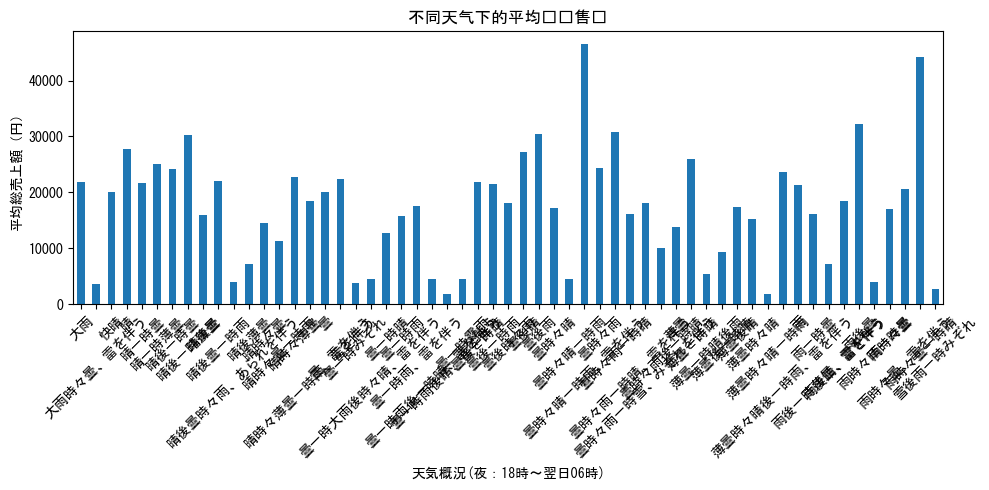

In [48]:
# ...existing code...
# 按白天天气分组，计算各类啤酒和总销售额的均值
grouped = merged_df.groupby('天気概況(夜：18時～翌日06時)')[
    ['ペールエール(円)', 'ラガー(円)', 'IPA(円)', 'ホワイトビール(円)', '黒ビール(円)', 'フルーツビール(円)', '総売上額']
].mean()

print(grouped)

# 可视化
import matplotlib.pyplot as plt

grouped['総売上額'].plot(kind='bar', figsize=(10,5))
plt.ylabel('平均総売上額（円）')
plt.title('不同天气下的平均总销售额')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# ...existing code...

気温区间
低温     20164.705882
中低温    22910.227273
中高温    19361.666667
高温     16537.500000
Name: 総売上額, dtype: float64


C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3339912634.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_grouped = merged_df.groupby('気温区间')['総売上額'].mean()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3339912634.py:16: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3339912634.py:16: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3339912634.py:16: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3339912634.py:16: UserWarning: Glyph 39069 (\N{CJK UNIFIE

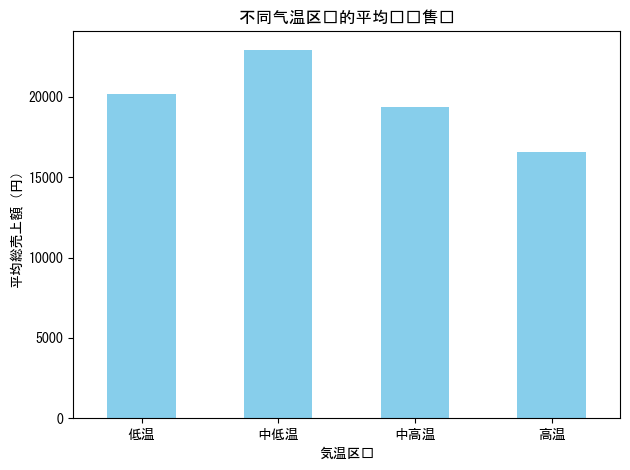

In [42]:
# ...existing code...
# 气温分箱
bins = [merged_df['平均気温(℃)'].min()-1, 10, 20, 30, merged_df['平均気温(℃)'].max()+1]
labels = ['低温', '中低温', '中高温', '高温']
merged_df['気温区间'] = pd.cut(merged_df['平均気温(℃)'], bins=bins, labels=labels)

# 各区间平均销售额
temp_grouped = merged_df.groupby('気温区间')['総売上額'].mean()
print(temp_grouped)

# 可视化
temp_grouped.plot(kind='bar', color='skyblue')
plt.ylabel('平均総売上額（円）')
plt.title('不同气温区间的平均总销售额')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
# ...existing code...

线性回归 R2分数: -0.006
岭回归 R2分数: -0.006
Lasso回归 R2分数: -0.006
决策树回归 R2分数: -0.872
随机森林回归 R2分数: -0.205


C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3437939618.py:50: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3437939618.py:50: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3437939618.py:50: UserWarning: Glyph 26641 (\N{CJK UNIFIED IDEOGRAPH-6811}) missing from font(s) MS Gothic.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3437939618.py:50: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) MS Gothic.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from font(s) MS Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylab

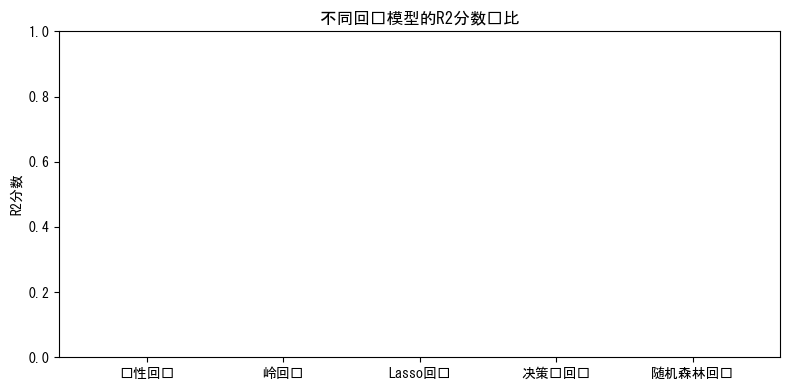

In [47]:
# ...existing code...
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

features = [
    '平均気温(℃)', '日照時間(時間)', '平均湿度(％)'
]
X = merged_df[features]
y = merged_df['総売上額']

# 去除缺失值
X = X.dropna()
y = y.loc[X.index]

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 假设X_scaled和y已经准备好
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    "线性回归": LinearRegression(),
    "岭回归": Ridge(alpha=1.0),
    "Lasso回归": Lasso(alpha=0.1),
    "决策树回归": DecisionTreeRegressor(random_state=42),
    "随机森林回归": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    results[name] = score
    print(f"{name} R2分数: {score:.3f}")

# 可视化对比
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel("R2分数")
plt.title("不同回归模型的R2分数对比")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
# ...existing code...

In [63]:
df['weekday'] = df['日付'].dt.weekday       # 0=周一 … 6=周日
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['month'] = df['日付'].dt.month
df['quarter'] = df['日付'].dt.quarter
df

,日付,平均気温(℃),日照時間(時間),降雪量合計(cm),平均湿度(％),最高気温(℃),最低気温(℃),10分間降水量の最大(mm),天気概況(昼：06時～18時),天気概況(夜：18時～翌日06時),...,ラガー(円),IPA(円),ホワイトビール(円),黒ビール(円),フルーツビール(円),総売上額,weekday,is_weekend,month,quarter
0,2024-04-01,14.6,3.8,0,73,19.7,11.8,1.5,曇時々雨一時晴,快晴,...,8000.0,4500.0,4500.0,4800.0,0.0,31800.0,0,0,4,2
1,2024-04-02,14.2,10.6,0,50,20.6,8.4,0.0,晴後薄曇,曇,...,5600.0,2700.0,3600.0,2400.0,1000.0,23300.0,1,0,4,2
2,2024-04-03,13.9,0.0,0,83,16.6,12.3,1.5,雨時々曇,雨時々曇,...,6400.0,5400.0,5400.0,2400.0,7000.0,33600.0,2,0,4,2
3,2024-04-04,15.4,0.1,0,79,19.9,11.3,1.5,曇一時雨,曇後一時雨,...,7200.0,3600.0,3600.0,1200.0,3000.0,24600.0,3,0,4,2
4,2024-04-05,11.4,0.0,0,71,15.1,9.0,0.5,曇時々雨,曇時々雨,...,14400.0,8100.0,7200.0,4800.0,7000.0,56500.0,4,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,2025-03-26,20.4,10.2,0,45,25.9,14.9,0.0,晴,薄曇時々晴,...,5600.0,2700.0,1800.0,2400.0,2000.0,20500.0,2,0,3,1
305,2025-03-27,17.9,5.6,0,69,22.4,12.2,0.0,薄曇一時晴,曇,...,800.0,900.0,0.0,0.0,1000.0,3700.0,3,0,3,1
306,2025-03-28,19.9,4.1,0,79,25.7,14.1,1.0,薄曇時々晴一時雨,雨時々曇一時晴,...,16000.0,10800.0,8100.0,6000.0,3000.0,68900.0,4,0,3,1
307,2025-03-29,7.6,0.0,0,90,14.3,4.3,1.0,雨,曇時々雨,...,800.0,0.0,0.0,0.0,0.0,1800.0,5,1,3,1


In [64]:
# 假设 df 已经：日付→datetime，総売上額→float
weekly = (
    df.set_index('日付')['総売上額']
      .resample('W-MON')       # 以“周一”作为周期标签
      .sum()                   # 计算周一前一周（周二～周日）之和
)
weekly.name = 'target_monday_order'
# 先算出周四当日的时间索引
# 取“W-THU”重采样标签为每周四
weekend = (
    df.set_index('日付')['総売上額']
      .resample('W-THU')
      .apply(lambda x: x.loc[x.index > x.index.max() - pd.Timedelta(days=3)].sum())
)
weekend.name = 'target_thu_restock'


In [65]:
weekly.index  # 已是周一日期
# 可以提取：
weekly_df = weekly.to_frame().assign(
    month=weekly.index.month,
    quarter=weekly.index.quarter,
    weekofyear=weekly.index.isocalendar().week
)


In [66]:
weather_feats = df.set_index('日付')[
    ['平均気温(℃)','日照時間(時間)', '平均湿度(％)']
]
mon_weather = weather_feats.resample('W-MON').mean().add_prefix('mon_')
thu_weather = weather_feats.resample('W-THU').mean().add_prefix('thu_')


In [67]:
weekly_df['lag1'] = weekly.shift(1)
weekly_df['roll4_mean'] = weekly.shift(1).rolling(4).mean()


In [68]:
thu_df = weekend.to_frame().assign(
    lag1=weekend.shift(1),
    roll2_mean=weekend.shift(1).rolling(2).mean()
)


In [69]:
X_mon = weekly_df.join(mon_weather).dropna()
y_mon = X_mon.pop('target_monday_order')

X_thu = thu_df.join(thu_weather).dropna()
y_thu = X_thu.pop('target_thu_restock')


In [70]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

tscv = TimeSeriesSplit(n_splits=5)
params = {'n_estimators':[100,300], 'learning_rate':[0.05,0.1], 'max_depth':[3,5]}

# 周一进货量
g_mon = GridSearchCV(LGBMRegressor(random_state=42), params, cv=tscv, scoring='r2')
g_mon.fit(X_mon, y_mon)
pred_mon = g_mon.predict(X_mon)
print("周一进货 R²:", r2_score(y_mon, pred_mon))

# 周四补货量
g_thu = GridSearchCV(LGBMRegressor(random_state=42), params, cv=tscv, scoring='r2')
g_thu.fit(X_thu, y_thu)
pred_thu = g_thu.predict(X_thu)
print("周四补货 R²:", r2_score(y_thu, pred_thu))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 9, number of used features: 0
[LightGBM] [Info] Start training from score 113433.333333
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 